<a href="https://colab.research.google.com/github/Haripolishetty/Deep_Learning_lab/blob/main/Week_9_Seq_Seq_Attension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import some required libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
import tensorflow as tf
import pickle as pkl
import numpy as np

The bellow link contains a dataset of numerous languages and its translation to English.
http://www.manythings.org/anki/

In [2]:
with open('/content/tel.txt','r') as f:
  data = f.read()

In [3]:
data

"Wonderful!\tఅద్భుతం!\tCC-BY 2.0 (France) Attribution: tatoeba.org #433510 (CK) & #10775002 (ramanirudh)\nDefinitely!\tతప్పకుండా\tCC-BY 2.0 (France) Attribution: tatoeba.org #30542 (CM) & #7233061 (bharath)\nHe hung up.\tఅతను పెట్టేసాడు\tCC-BY 2.0 (France) Attribution: tatoeba.org #301817 (CK) & #7207796 (bharath)\nI ran home.\tనేను ఇంటికి పరిగెత్తాను\tCC-BY 2.0 (France) Attribution: tatoeba.org #2246046 (CK) & #7217065 (bharath)\nWho are we?\tమేము ఎవరము ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2254698 (CK) & #7207797 (bharath)\nAre you mad?\tకోపమొచ్చిందా ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #18965 (CK) & #7210858 (bharath)\nHe's my son.\tఅతను మా అబ్బాయి\tCC-BY 2.0 (France) Attribution: tatoeba.org #4703087 (CH) & #7216983 (bharath)\nHe touched me.\tఅతను నన్ను తాకాడు\tCC-BY 2.0 (France) Attribution: tatoeba.org #1635587 (Spamster) & #7216926 (bharath)\nMy head hurts.\tనా తల నొప్పిపుడుతుంది\tCC-BY 2.0 (France) Attribution: tatoeba.org #456425 (lukaszpp) & #7207771 (bhar

As you can see that it is a raw text file and hence it is necessary to clean and transform it as per our preference. We will separate Telugu and English sentences and form a list of it, continuing it by storing it into a dataframe so that it's easy for us to reuse it again easily.

### Preprocessing Dataset

In [4]:
uncleaned_data_list = data.split('\n')  # Split the data into a list of lines
len(uncleaned_data_list)  # Check the length of the list

uncleaned_data_list = uncleaned_data_list[:38695]  # Truncate the list to a specific length
len(uncleaned_data_list)  # Check the length again

english_word = []
telugu_word = []
cleaned_data_list = []

# Iterate over the truncated list and split each line by '\t'
for word in uncleaned_data_list:
    split_word = word.split('\t')

    # Check if the split_word list has at least two elements before trying to access them
    if len(split_word) >= 2:
        english_word.append(split_word[0])  # Access the first element
        telugu_word.append(split_word[1])   # Access the second element

# Create a DataFrame using pandas
language_data = pd.DataFrame(columns=['English', 'Telugu'])
language_data['English'] = english_word
language_data['Telugu'] = telugu_word

# Save the DataFrame to a CSV file
language_data.to_csv('language_data.csv', index=False)


In [5]:
language_data.head()

,English,Telugu
0,Wonderful!,అద్భుతం!
1,Definitely!,తప్పకుండా
2,He hung up.,అతను పెట్టేసాడు
3,I ran home.,నేను ఇంటికి పరిగెత్తాను
4,Who are we?,మేము ఎవరము ?


In [6]:
english_text = language_data['English'].values
telugu_text = language_data['Telugu'].values
len(english_text), len(telugu_text)

(154, 154)

### Data Cleaning

In [7]:
# Convert to lower case
english_text_ = [x.lower() for x in english_text]
telugu_text_ = [x.lower() for x in telugu_text]

# Remove inverted commas
english_text_ = [re.sub("'", '', x) for x in english_text]
telugu_text_ = [re.sub("'", '', x) for x in telugu_text]

def remove_punc(text_list):
    table = str.maketrans('', '', string.punctuation)
    removed_punc_text = []
    for sent in text_list:
        sentence = [w.translate(table) for w in sent.split(' ')]
        removed_punc_text.append(' '.join(sentence))
    return removed_punc_text

english_text_ = remove_punc(english_text_)
telugu_text_ = remove_punc(telugu_text)

remove_digits = str.maketrans('', '', digits)
removed_digits_text = []

for sent in english_text_:
    sentence = [w.translate(remove_digits) for w in sent.split(' ')]
    removed_digits_text.append(' '.join(sentence))

english_text_ = removed_digits_text

# Remove digits from the Telugu sentences
telugu_text_ = [re.sub("[౨౩౦౮౧౫౭౯౪౬]", "", x) for x in telugu_text]
telugu_text_ = [re.sub("[\u200d]", "", x) for x in telugu_text]

# Remove leading and trailing whitespaces
english_text_ = [x.strip() for x in english_text]
telugu_text_ = [x.strip() for x in telugu_text]


In [8]:
# Adding ‘start’ and ‘end’ tag to telugu sentence.
#This will help the decoder to know from where to start decoding and when to end.
telugu_text_ = ["start " + x + " end" for x in telugu_text_]
# manipulated_telugu_text
telugu_text_[0], english_text_[0]

('start అద్భుతం! end', 'Wonderful!')

### Data preparation for model building

In [9]:
X = english_text_
Y = telugu_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

 What is the maximum length of our sentences in both English and Telugu?

In [10]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(X_train)
max_length_telugu = Max_length(y_train)
#Test data
max_length_english_test = Max_length(X_test)
max_length_telugu_test = Max_length(y_test)
max_length_telugu, max_length_english

(12, 13)

### Tokenization

In [11]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1
X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')
teluguTokenizer = Tokenizer()
teluguTokenizer.fit_on_texts(y_train)
Tword2index = teluguTokenizer.word_index
vocab_size_target = len(Tword2index) + 1
y_train = teluguTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_telugu, padding='post')
y_test = teluguTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_telugu, padding='post')
vocab_size_source, vocab_size_target

(347, 408)

In [12]:
#with open('NMT_data.pkl','wb') as f:
  #pkl.dump([X_train, y_train, X_test, y_test],f)
#with open('NMT_Etokenizer.pkl','wb') as f:
  #pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)
#with open('NMT_Mtokenizer.pkl', 'wb') as f:
  #pkl.dump([vocab_size_target, Mword2index, marathiTokenizer], f)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
from attention import AttentionLayer



We will be using a third party attention mechanism. You can download the attention layer from bellow repository and copy it in a different file called attention.py. This attention is an implementation of ‘Bahdanau Attention’ .

https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

In [14]:
# Attention Mechanism
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units):
    super(AttentionLayer, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [15]:
from attention import AttentionLayer


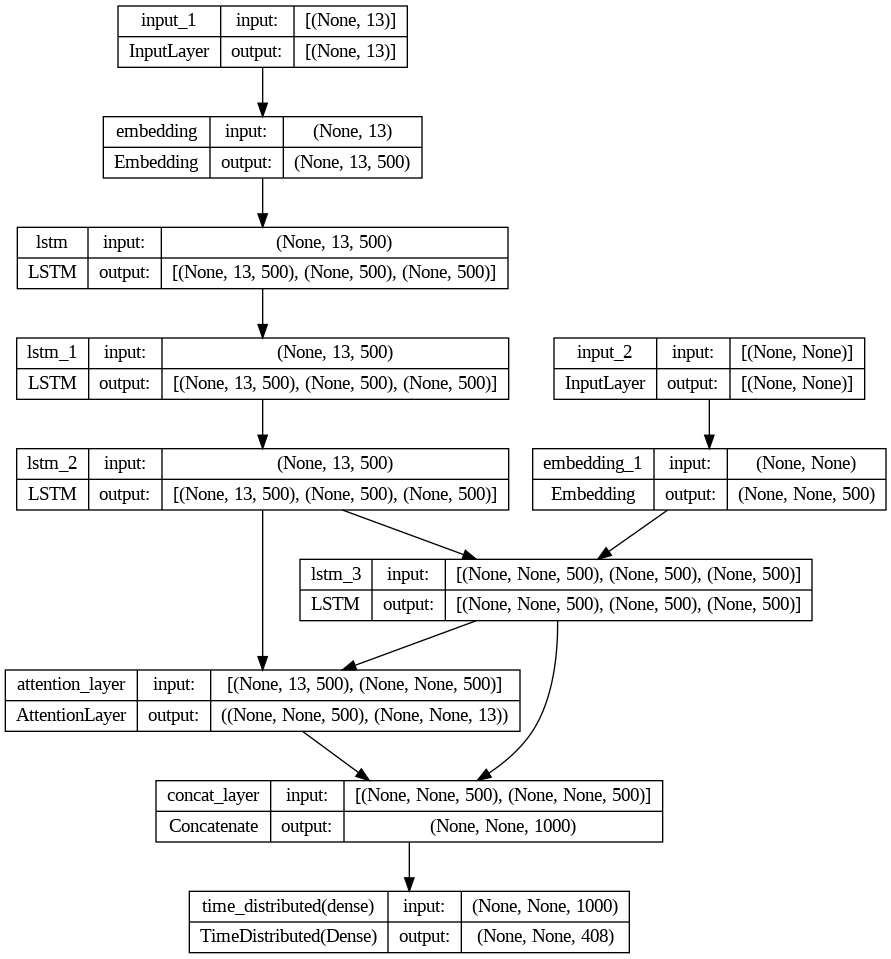

In [16]:

from keras import backend as K
K.clear_session()
latent_dim = 500
# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
#Attention Layer
attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='train_model.png', show_shapes=True)

### Compile model

In [17]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train model

In [18]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]],           y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
1/1 [==============================] - 33s 33s/step - loss: 6.0054 - accuracy: 0.0000e+00 - val_loss: 5.7742 - val_accuracy: 0.8125
Epoch 2/50
1/1 [==============================] - 0s 123ms/step - loss: 5.8771 - accuracy: 0.5211 - val_loss: 5.4887 - val_accuracy: 0.8125
Epoch 3/50
1/1 [==============================] - 0s 107ms/step - loss: 5.7192 - accuracy: 0.5211 - val_loss: 4.8138 - val_accuracy: 0.8125
Epoch 4/50
1/1 [==============================] - 0s 96ms/step - loss: 5.3505 - accuracy: 0.5211 - val_loss: 1.6010 - val_accuracy: 0.8125
Epoch 5/50
1/1 [==============================] - 0s 87ms/step - loss: 3.2155 - accuracy: 0.5211 - val_loss: 1.7668 - val_accuracy: 0.8125
Epoch 6/50
1/1 [==============================] - 0s 84ms/step - loss: 5.8500 - accuracy: 0.5211 - val_loss: 2.0390 - val_accuracy: 0.8409
Epoch 7/50
1/1 [==============================] - 0s 92ms/step - loss: 3.0890 - accuracy: 0.5231 - val_loss: 0.9693 - val_accuracy: 0.8125
Epoch 8/50
1/1 [=====

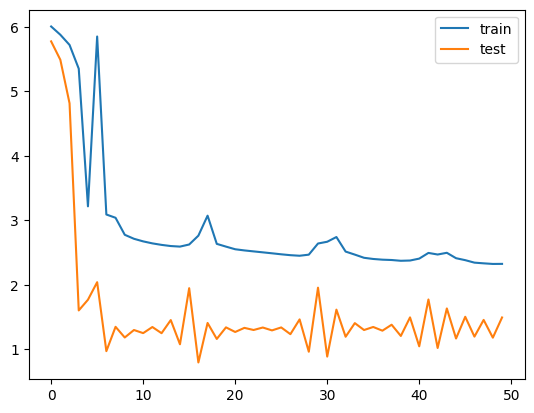

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Model Saving and Loading

In [20]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


### Load model:

In [21]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

### Inference Model

In [22]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(9,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

### Predictions

In [28]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Tword2index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
            break
        else:
            sampled_token = Tindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [30]:
Eindex2word = englishTokenizer.index_word
Tindex2word = teluguTokenizer.index_word

In [31]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Tword2index['start']) and i!=Tword2index['end']):
        newString=newString+Tindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [33]:
from keras.preprocessing.sequence import pad_sequences

# For each test sample
for i in range(len(X_test)):
    # Assuming X_test[i] is the input sequence
    X_test_padded = pad_sequences([X_test[i]], maxlen=9, padding='post')
    predicted_summary = decode_sequence(X_test_padded)

    print("Review:", seq2text(X_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", predicted_summary)
    print("\n")


1/1 [==============================] - 0s 38ms/step
Review: people 
Original summary: 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 38ms/step
Review: you have no need to be 
Original summary: నువ్వు లేదు 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 20ms/step
Review: when will you next 
Original summary: 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 20ms/step
Review: the is 
Original summary: వుంది 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 23ms/step
Review: my hurts 
Original summary: నా 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 21ms/step
Review: we in 
Original summary: మేము 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 20ms/step
Review: are you 
Original summary: 
Predicted summary:  నేను నేను


1/1 [==============================] - 0s 26ms/step
Review: can you that 
Original summary: నువ్వు అది 
Predict

In [34]:
for i in range(10):
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print(X_test[i].shape)
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,13)))
  print("\n")



Review: people 
Original summary: 
(13,)
1/1 [==============================] - 0s 22ms/step
Predicted summary:  నువ్వు నేను


Review: you have no need to be 
Original summary: నువ్వు లేదు 
(13,)
1/1 [==============================] - 0s 21ms/step
Predicted summary:  నేను నేను


Review: when will you next 
Original summary: 
(13,)
1/1 [==============================] - 0s 21ms/step
Predicted summary:  నేను నేను


Review: the is 
Original summary: వుంది 
(13,)
1/1 [==============================] - 0s 21ms/step
Predicted summary:  నేను నేను


Review: my hurts 
Original summary: నా 
(13,)
1/1 [==============================] - 0s 21ms/step
Predicted summary:  నేను నేను


Review: we in 
Original summary: మేము 
(13,)
1/1 [==============================] - 0s 20ms/step
Predicted summary:  నేను నేను


Review: are you 
Original summary: 
(13,)
1/1 [==============================] - 0s 22ms/step
Predicted summary:  నేను నేను


Review: can you that 
Original summary: నువ్వు అది 
(13,)
1/1 [====

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dot

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='attention_weights')
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True,
                                 name='attention_bias')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)  # Dot product using matrix multiplication
        q += self.b
        q = tf.nn.tanh(q)
        scores = tf.nn.softmax(q, axis=-2)  # Compute softmax along the sequence length
        attention_output = tf.reduce_sum(scores * inputs, axis=-2)  # Compute the weighted sum
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape

# Test the attention layer
# Assume input_shape = (batch_size, sequence_length, num_features)
input_shape = (None, 10, 64)  # Example input shape
inputs = tf.keras.Input(shape=input_shape)
attention_output = SelfAttention()(inputs)
model = tf.keras.Model(inputs=inputs, outputs=attention_output)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 10, 64)]    0         
                                                                 
 self_attention_1 (SelfAtte  (None, None, 64)          4160      
 ntion)                                                          
                                                                 
Total params: 4160 (16.25 KB)
Trainable params: 4160 (16.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
